In [ ]:
pip install np_utils

     |████████████████████████████████| 61 kB 476 kB/s 
  Created wheel for np-utils: filename=np_utils-0.6.0-py3-none-any.whl size=56459 sha256=8e0b0764937189be8f7cba113537010bc763a5790f55857df76322f9da3c84cf
  Stored in directory: /root/.cache/pip/wheels/d2/83/71/a781667865955ae7dc18e5a4038401deb56d96eb85d3a5f1c0
Successfully built np-utils


In [ ]:
import numpy as np
from numpy import zeros, ones, expand_dims
from numpy.random import randn, randint
import tensorflow as tf
from keras.models import Model
from keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from keras.layers import Input,Dense,Reshape,Flatten,Conv2D,Conv2DTranspose
from keras.layers import LeakyReLU,BatchNormalization,Dropout,Embedding,Activation,Concatenate
from keras.initializers import RandomNormal
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

In [ ]:
def define_discriminator(in_shape=(32,32,3), n_classes=10):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # image input
  in_image = Input(shape=in_shape)
  # normal
  fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(in_image)
  fe = BatchNormalization()(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  fe = Dropout(0.5)(fe)
  # downsample to 8x8
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
  fe = BatchNormalization()(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  fe = Dropout(0.5)(fe)
  # normal
  fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
  fe = BatchNormalization()(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  fe = Dropout(0.5)(fe)
  # flatten feature maps
  fe = Flatten()(fe)
  # real/fake output
  out1 = Dense(1, activation='sigmoid')(fe)
  # class label output
  out2 = Dense(n_classes, activation='softmax')(fe)
  # define model
  model = Model(in_image, [out1, out2])
  # compile model
  opt = Adam(lr=0.0002, betza_1=0.5)
  model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
  #model.summary()
  return model

In [ ]:
def define_generator(latent_dim, n_classes=10):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # label input
  in_label = Input(shape=(1,))
  # embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
  # linear multiplication
  n_nodes = 4 * 4
  li = Dense(n_nodes, kernel_initializer=init)(li)
  # reshape to additional channel
  li = Reshape((4,4, 1))(li)
  # image generator input
  in_lat = Input(shape=(latent_dim,))
  # foundation for 4x4 image
  n_nodes = 256 * 4 * 4
  gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
  gen = Activation('relu')(gen)
  gen = Reshape((4, 4, 256))(gen)
  # merge image gen and label input
  merge = Concatenate()([gen, li])
  # upsample
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merge)
  gen = BatchNormalization()(gen)
  gen = Activation('relu')(gen)
  # upsample
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
  gen = BatchNormalization()(gen)
  gen = Activation('relu')(gen)
  # upsample
  # gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
  # gen = BatchNormalization()(gen)
  # gen = Activation('relu')(gen)

  gen = Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
  out_layer = Activation('tanh')(gen)
  
  model = Model([in_lat, in_label], out_layer)
  return model

In [ ]:
# model.output_shape #chand?

In [ ]:
def define_gan(g_model, d_model):
  d_model.trainable = False
  gan_output = d_model(g_model.output)
  model = Model(g_model.input, gan_output)
  
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
  return model

In [ ]:
def generate_real_samples(dataset, n_samples):
	images, labels = dataset
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

def generate_latent_points(latent_dim, n_samples, n_classes=10):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

In [ ]:
latent_dim = 100
n_batch = 64
epochs = 100

d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
d_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 64)   0           ['batch_normalization[0][0]']

In [ ]:
g_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 4096)         413696      ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_2[0][0]']                
                                                                                            

In [ ]:
def load_real_samples():
	(trainX, trainy), (_, _) = load_data()
	X_train = np.float32(trainX)
 
	# scale from [0,255] to [-1,1]
	X_train = (X_train / 255 - 0.5) * 2
	X_train = np.clip(X_train, -1, 1)
	#X = (X - 127.5) / 127.5
	return [X_train,trainy]
dataset = load_real_samples()

170508288/170498071 [==============================] - 3s 0us/step


In [ ]:
dataset[0].shape

(50000, 32, 32, 3)

epoch = 1/100, d_loss=0.001,d_loss_label=1.341, g_loss=0.027, g_loss_label=0.020                                                                                                     


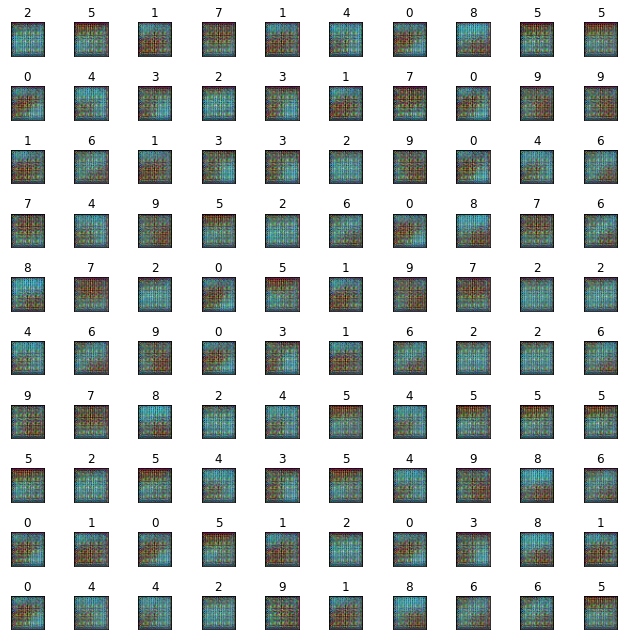

epoch = 2/100, d_loss=0.001,d_loss_label=1.045, g_loss=0.013, g_loss_label=0.001                                                                                                     
epoch = 3/100, d_loss=0.023,d_loss_label=0.986, g_loss=0.009, g_loss_label=0.043                                                                                                     
epoch = 4/100, d_loss=0.000,d_loss_label=0.843, g_loss=0.002, g_loss_label=0.002                                                                                                     
epoch = 5/100, d_loss=0.000,d_loss_label=0.762, g_loss=0.005, g_loss_label=0.002                                                                                                     
epoch = 6/100, d_loss=0.000,d_loss_label=0.584, g_loss=0.001, g_loss_label=0.001                                                                                                     
epoch = 7/100, d_loss=0.000,d_loss_label=0.727, g_loss=0.001, g_loss_label=0.001          

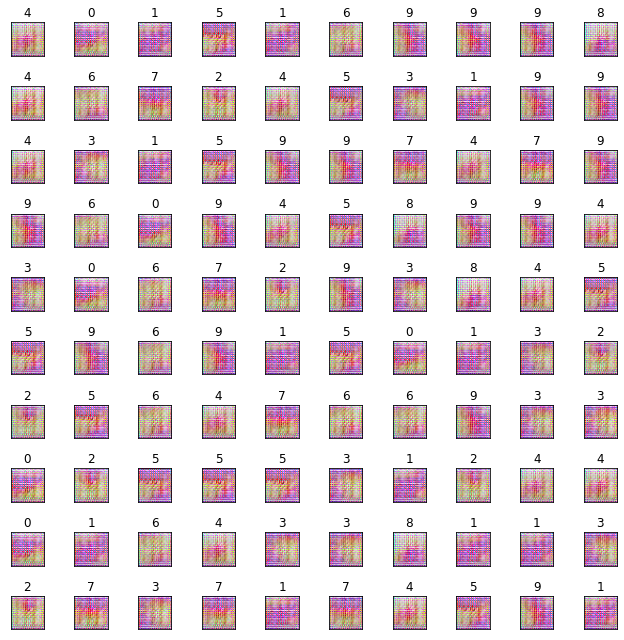

epoch = 12/100, d_loss=0.000,d_loss_label=0.553, g_loss=0.000, g_loss_label=0.001                                                                                                     
epoch = 13/100, d_loss=0.000,d_loss_label=0.497, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 14/100, d_loss=0.000,d_loss_label=0.516, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 15/100, d_loss=0.000,d_loss_label=0.309, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 16/100, d_loss=0.000,d_loss_label=0.734, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 17/100, d_loss=0.000,d_loss_label=0.447, g_loss=0.000, g_loss_label=0.000    

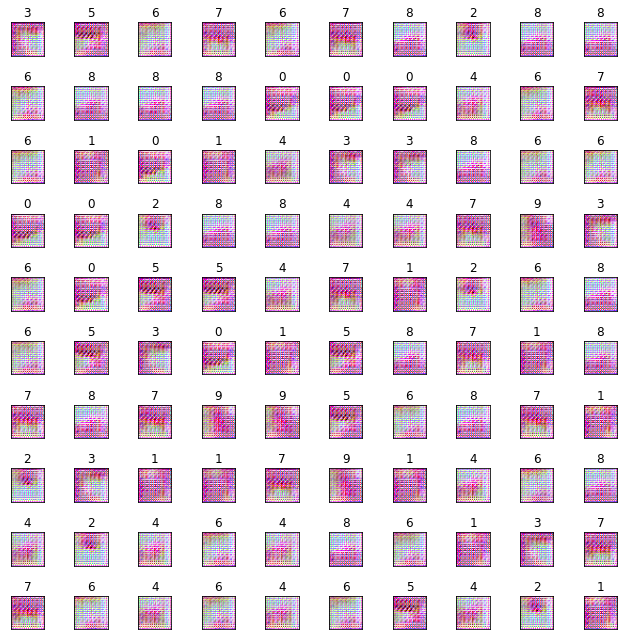

epoch = 22/100, d_loss=0.000,d_loss_label=0.460, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 23/100, d_loss=0.000,d_loss_label=0.471, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 24/100, d_loss=0.000,d_loss_label=0.470, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 25/100, d_loss=0.000,d_loss_label=0.394, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 26/100, d_loss=0.000,d_loss_label=0.327, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 27/100, d_loss=0.000,d_loss_label=0.182, g_loss=0.000, g_loss_label=0.000    

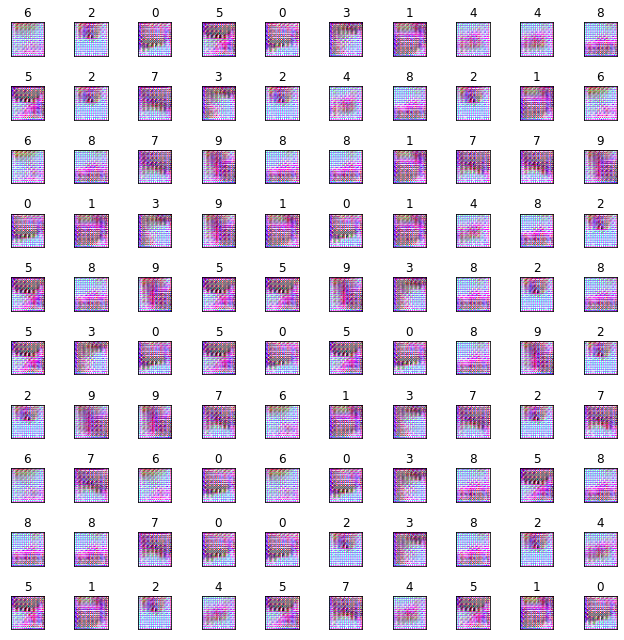

epoch = 32/100, d_loss=0.000,d_loss_label=0.403, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 33/100, d_loss=0.000,d_loss_label=0.559, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 34/100, d_loss=0.000,d_loss_label=0.410, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 35/100, d_loss=0.000,d_loss_label=0.269, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 36/100, d_loss=0.000,d_loss_label=0.189, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 37/100, d_loss=0.000,d_loss_label=0.520, g_loss=0.000, g_loss_label=0.000    

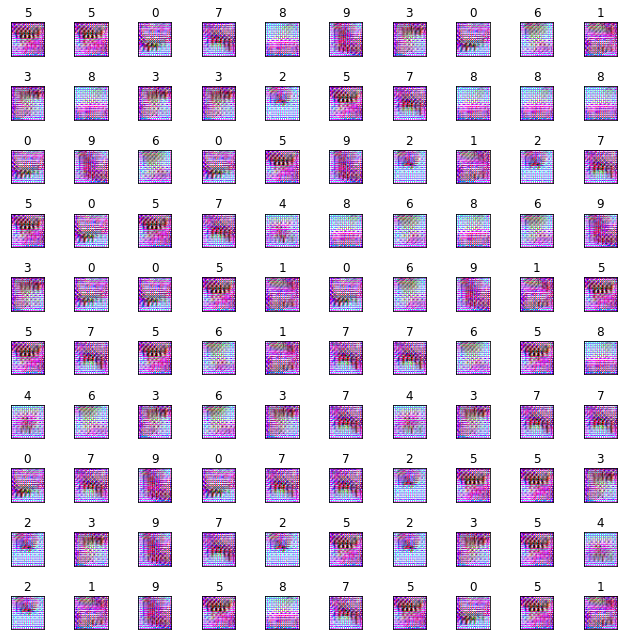

epoch = 42/100, d_loss=0.000,d_loss_label=0.496, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 43/100, d_loss=0.000,d_loss_label=0.437, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 44/100, d_loss=0.000,d_loss_label=0.461, g_loss=0.000, g_loss_label=0.001                                                                                                     
epoch = 45/100, d_loss=0.000,d_loss_label=0.293, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 46/100, d_loss=0.000,d_loss_label=0.217, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 47/100, d_loss=0.000,d_loss_label=0.219, g_loss=0.000, g_loss_label=0.000    

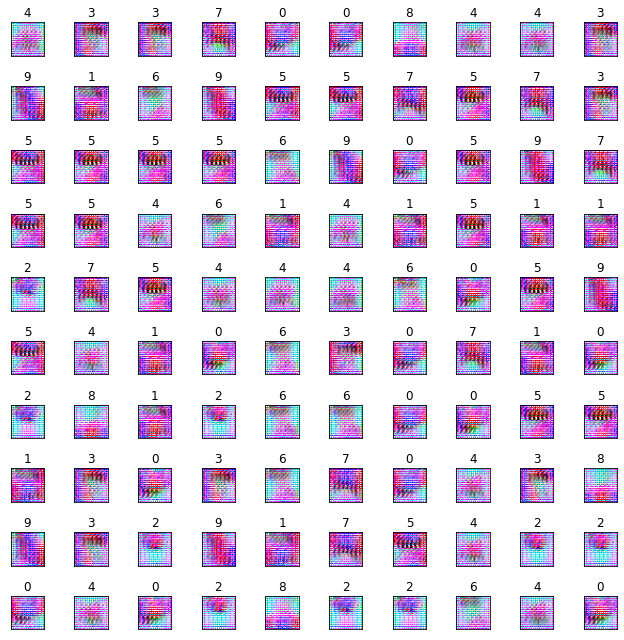

epoch = 52/100, d_loss=0.000,d_loss_label=0.254, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 53/100, d_loss=0.000,d_loss_label=0.322, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 54/100, d_loss=0.000,d_loss_label=0.413, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 55/100, d_loss=0.000,d_loss_label=0.161, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 56/100, d_loss=0.000,d_loss_label=0.386, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 57/100, d_loss=0.000,d_loss_label=0.203, g_loss=0.000, g_loss_label=0.000    

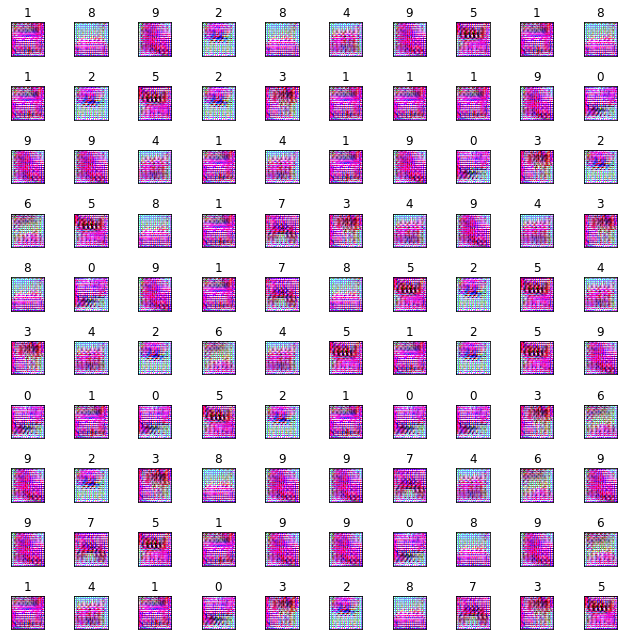

epoch = 62/100, d_loss=0.000,d_loss_label=0.240, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 63/100, d_loss=0.000,d_loss_label=0.323, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 64/100, d_loss=0.000,d_loss_label=0.489, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 65/100, d_loss=0.000,d_loss_label=0.288, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 66/100, d_loss=0.000,d_loss_label=0.154, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 67/100, d_loss=0.000,d_loss_label=0.182, g_loss=0.000, g_loss_label=0.000    

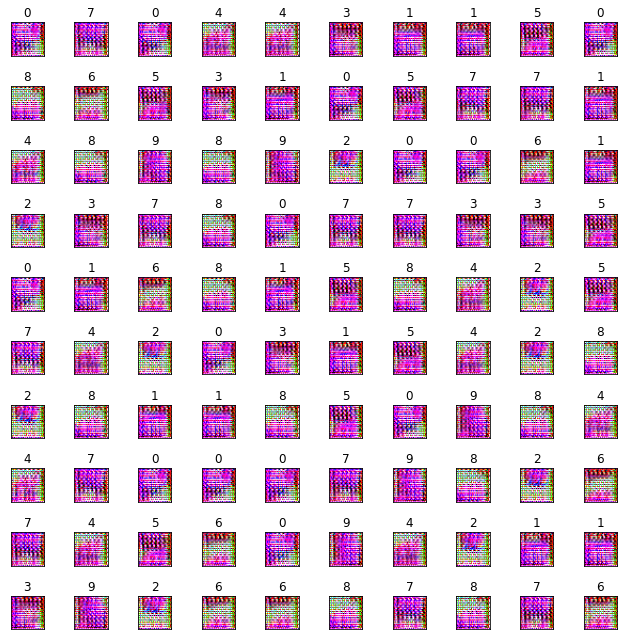

epoch = 72/100, d_loss=0.000,d_loss_label=0.255, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 73/100, d_loss=0.000,d_loss_label=0.236, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 74/100, d_loss=0.000,d_loss_label=0.357, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 75/100, d_loss=0.000,d_loss_label=0.133, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 76/100, d_loss=0.000,d_loss_label=0.247, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 77/100, d_loss=0.000,d_loss_label=0.366, g_loss=0.000, g_loss_label=0.000    

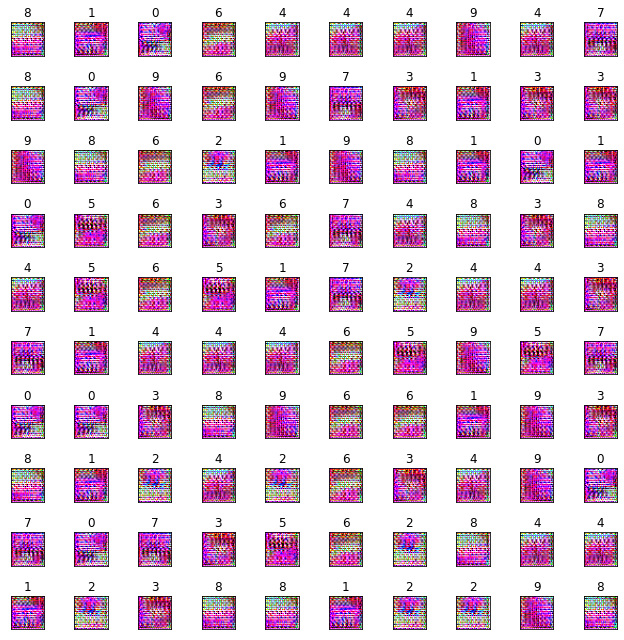

epoch = 82/100, d_loss=0.000,d_loss_label=0.198, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 83/100, d_loss=0.000,d_loss_label=0.390, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 84/100, d_loss=0.000,d_loss_label=0.189, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 85/100, d_loss=0.000,d_loss_label=0.316, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 86/100, d_loss=0.000,d_loss_label=0.135, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 87/100, d_loss=0.000,d_loss_label=0.165, g_loss=0.000, g_loss_label=0.000    

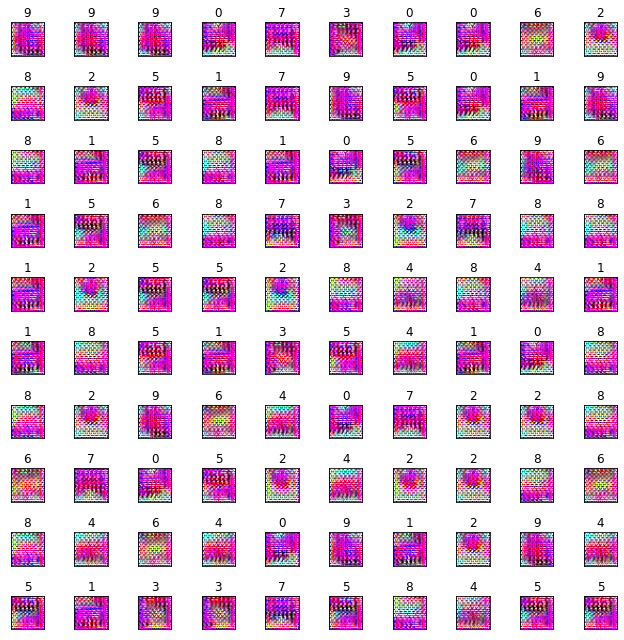

epoch = 92/100, d_loss=0.000,d_loss_label=0.256, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 93/100, d_loss=0.000,d_loss_label=0.276, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 94/100, d_loss=0.000,d_loss_label=0.201, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 95/100, d_loss=0.000,d_loss_label=0.388, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 96/100, d_loss=0.000,d_loss_label=0.408, g_loss=0.000, g_loss_label=0.000                                                                                                     
epoch = 97/100, d_loss=0.000,d_loss_label=0.168, g_loss=0.000, g_loss_label=0.000    

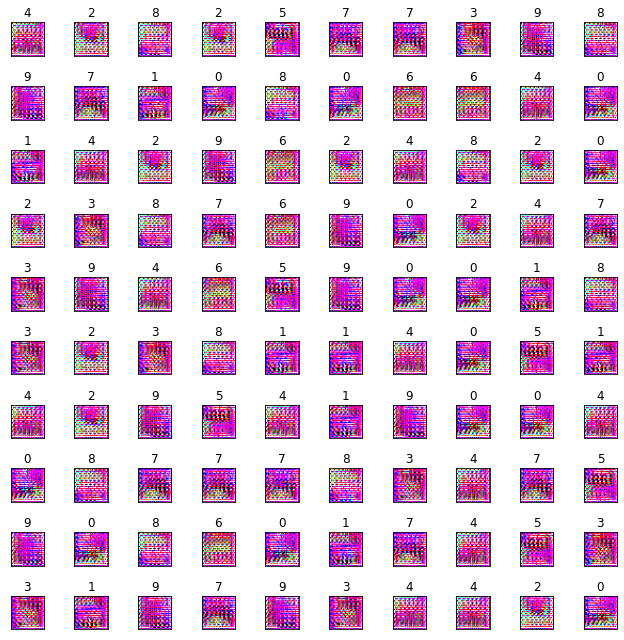

In [ ]:
n_steps = int(dataset[0].shape[0] / n_batch)
half_batch = int(n_batch / 2)
d_loss = []
d_g_loss = []
d_loss_label = []
d_g_loss_label = []
for e in range(epochs + 1):
  for i in range(n_steps):

    # get randomly selected 'real' samples
    [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
    # update discriminator model weights
    _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])

    # generate 'fake' examples
    [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    
    # update discriminator model weights
    _,d_f1,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
    #distriminator loss 
    d_loss_batch = 0.5 * (d_r1+ d_f1)
    d_label_batch = 0.5 * (d_r2+ d_f2)

    # prepare points in latent space as input for the generator
    [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
    
    # create inverted labels for the fake samples
    y_gan = ones((n_batch, 1))

    # update the generator via the discriminator's error
    _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
    print('epoch = %d/%d, batch = %d/%d, d_loss=%.3f d_loss_label=%.3f , g_loss=%.3f g_loss_label=%.3f' % (e + 1, epochs, i,n_steps, d_loss_batch,d_label_batch, g_1,g_2),100*' ',end='\r')
     
  d_loss.append(d_loss_batch)
  d_g_loss.append(g_1)
  d_loss_label.append(d_label_batch)
  d_g_loss_label.append(g_2)
  print('epoch = %d/%d, d_loss=%.3f,d_loss_label=%.3f, g_loss=%.3f, g_loss_label=%.3f' % (e + 1, epochs, d_loss[-1], d_loss_label[-1], d_g_loss[-1], d_g_loss_label[-1]), 100*' ')
  if e % 10 == 0:
    samples = 100
    [x_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, samples)
    x_fake = np.clip(x_fake, -1, 1)
    #x_fake = (x_fake + 1) * 127
    #x_fake = np.round(x_fake).astype('uint8')
    plt.figure(figsize=(9,9))
    for k in range(samples):
      plt.subplot(10, 10, k + 1, xticks=[], yticks=[])
      plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))
      plt.title(labels_fake[k])

    plt.tight_layout()
    plt.show()

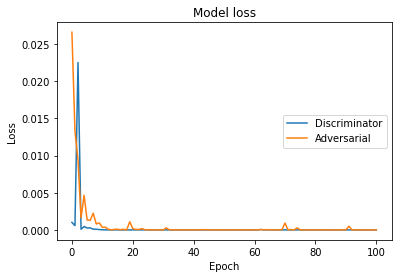

In [ ]:
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

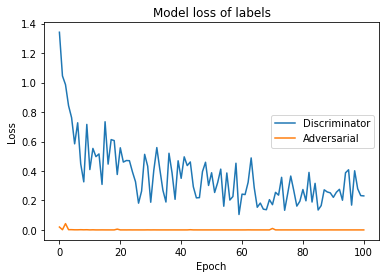

In [ ]:
plt.plot(d_loss_label)
plt.plot(d_g_loss_label)
plt.title('Model loss of labels')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()